# Evaluation

This notebook evaluates the performance of the QRNN-based retrieval against GPROF using real GMI observations co-located with observations from the GPROF a priori database. The surface precipitation from the a priori database will is taken as reference (``y_true``) to compare the predictions from the other two algorithms (``y_gprof`` and ``y_pred``).

## Setup

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from regn.data.gprof import GMIDataset, GMITestset
import quantnn as q
from regn import regn_path
plt.style.use(str(regn_path / "misc" / "matplotlib_style.rc"))

In [3]:
training_data = GMIDataset("../../data/training_data_gmi_large.nc",
                       batch_size=256)
test_data = GMITestset("../../data/test_data_gmi_small.nc",
                       batch_size=256,
                       shuffle=False,
                       normalizer=training_data.normalizer)
test_data.transform_log()
test_data.y = np.exp(test_data.y)

In [4]:
from quantnn import QRNN
qrnn = QRNN.load(regn_path / "models" / "qrnn_gmi.pt")

/home/simonpf/src/regn_test/regn/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/simonpf/src/regn_test/regn/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/simonpf/src/regn_test/regn/lib/python3.7/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm1d' has changed. you can retrieve t

## Calibration

To evaluate the reliability of the predicted uncertainties, we calculate the calibration of the QRNN-dervied uncertainty intervals together with the calibration of the 1st and 3rd terciles predicted by GPROF.

In [5]:
x_qrnn, y_qrnn = qrnn.calibration(test_data)

gprof_1st = test_data.y_1st_tercile
gprof_3rd = test_data.y_3rd_tercile
y_true = test_data.y_true
x_gprof = [0.33, 0.66]
y_gprof = [np.mean(test_data.y.ravel() <= gprof_1st.ravel()),
           np.mean(test_data.y.ravel() <= gprof_3rd.ravel())]

100%|██████████| 640/640 [00:03<00:00, 179.48it/s]


Text(0, 0.5, 'Observed fraction')

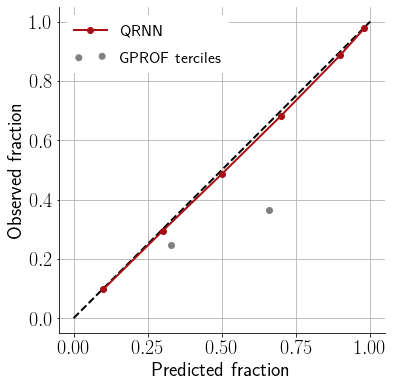

In [6]:
x_ref = np.linspace(0, 1, 41)
f, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(x_ref, x_ref, ls="--", c="k")
ax.plot(x_qrnn, y_qrnn, marker="o", label="QRNN")
ax.scatter(x_gprof, y_gprof, marker="o", c="grey", label="GPROF terciles")
ax.legend()
ax.set_aspect(1.0)
ax.set_xlabel("Predicted fraction")
ax.set_ylabel("Observed fraction")

## Point predictions

Next, we evaluate the accuracy of point prediction derived using GPROF and the QRNN. Here the surface
precipitation predicted by GPROF (``y_gprof``) is compared to the QRNN-derived median and posterior mean
(``y_qrnn_median`` and ``y_qrnn_mean``).

In [7]:
y_true = test_data.y
y_gprof = test_data.y_gprof

y_pred = qrnn.predict(test_data.x)
y_qrnn_mean = q.posterior_mean(y_pred, qrnn.quantiles).reshape(-1, 1)
y_qrnn_median = y_pred[:, len(qrnn.quantiles) // 2]

In [8]:
dy_gprof = y_gprof - y_true
dy_qrnn_mean = y_qrnn_mean.ravel() - y_true.ravel()
dy_qrnn_median = y_qrnn_median.ravel() - y_true.ravel()

In [9]:
import pandas as pd
errors = pd.DataFrame({"y_true": y_true.ravel(),
                       "surface_type": test_data.surface_type.ravel(),
                       "GPROF": dy_gprof.ravel(),
                       "QRNN mean": dy_qrnn_mean.ravel(),
                       "QRNN median": dy_qrnn_median.ravel()},
                      index=np.arange(dy_gprof.shape[0]))

### 

### Error statistics

In [10]:
mses = errors.apply(lambda x: (x**2).mean())[["GPROF", "QRNN mean", "QRNN median"]]
maes = errors.apply(lambda x: x.abs().mean())[["GPROF", "QRNN mean", "QRNN median"]]
biases = errors.apply(lambda x: x.mean())[["GPROF", "QRNN mean", "QRNN median"]]

pd.DataFrame({"Mean squared errors": mses,
              "Mean absolute errors": maes,
              "Biases": biases})

,Mean squared errors,Mean absolute errors,Biases
GPROF,0.177383,0.066332,0.001084
QRNN mean,0.143044,0.046920,-0.004530
QRNN median,0.140374,0.043188,-0.018823


In [11]:
errors_rain = errors[errors["y_true"] < 0.1]
mses = errors_rain.apply(lambda x: (x**2).mean())[["GPROF", "QRNN mean", "QRNN median"]]
maes = errors_rain.apply(lambda x: x.abs().mean())[["GPROF", "QRNN mean", "QRNN median"]]
biases = errors_rain.apply(lambda x: x.mean())[["GPROF", "QRNN mean", "QRNN median"]]

pd.DataFrame({"Mean squared error": mses,
              "Mean absolute error": maes,
              "Bias": biases})

,Mean squared error,Mean absolute error,Bias
GPROF,0.003241,0.023973,0.021689
QRNN mean,0.002736,0.010964,0.008317
QRNN median,0.001809,0.005579,0.001145


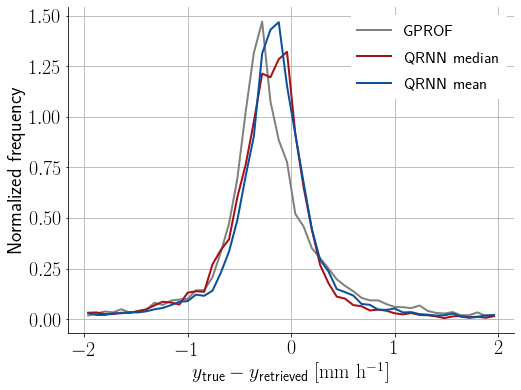

In [12]:
bins = np.linspace(-2, 2, 51)
inds = y_true.ravel() > 0.3
y_gprof, _ = np.histogram(dy_gprof[inds], bins=bins, density=True)
y_qrnn_mean, _ = np.histogram(dy_qrnn_mean[inds], bins=bins, density=True)
y_qrnn_median, _ = np.histogram(dy_qrnn_median[inds], bins=bins, density=True)
x = 0.5 * (bins[1:] + bins[:-1])

f, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(x, y_gprof, c="grey", label="GPROF")
ax.plot(x, y_qrnn_median, label="QRNN median")
ax.plot(x, y_qrnn_mean, label="QRNN mean")
l = ax.set_xlabel(r"$y_\text{true} - y_\text{retrieved}$ $[\unit{mm\ h^{-1}}]$ ")
l = ax.set_ylabel("Normalized frequency")
l = ax.legend()

In [13]:
mses = errors.groupby("surface_type").apply(lambda x: (x ** 2).mean())
biases = errors.groupby("surface_type").apply(lambda x: x.mean())

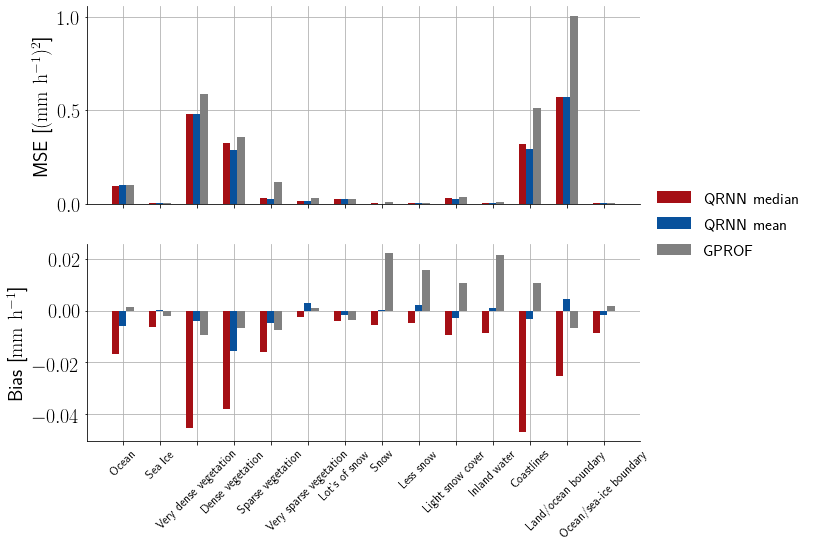

In [14]:
from matplotlib.gridspec import GridSpec
gs = GridSpec(2, 2, width_ratios=[1.0, 0.1])
f = plt.figure(figsize=(12, 8))

x = np.arange(14)
w = 0.2

surface_types = ["Ocean",
                 "Sea Ice",
                 "Very dense vegetation",
                 "Dense vegetation ",
                 "Sparse vegetation",
                 "Very sparse vegetation",
                 "Lot's of snow",
                 "Snow",
                 "Less snow",
                 "Light snow cover",
                 "Inland water",
                 "Coastlines",
                 "Land/ocean boundary",
                 "Ocean/sea-ice boundary"]

#
# MSE
#

ax = plt.subplot(gs[0, 0])
ax.bar(x + 0.0 * w, mses["QRNN median"], width=w, zorder=10)
ax.bar(x + 1.0 * w, mses["QRNN mean"], width=w, zorder=10)
ax.bar(x + 2.0 * w, mses["GPROF"], width=w, color="grey", zorder=10)
ax.set_ylabel(r"MSE [$(\unit{mm\ h^{-1}})^2$]")
ax.set_xticks(x + 1 * w)
ax.set_xticklabels([])

#
# Bias
#


ax = plt.subplot(gs[1, 0])
r_median = ax.bar(x + 0.0 * w, biases["QRNN median"], width=w, zorder=10)
r_mean = ax.bar(x + 1.0 * w, biases["QRNN mean"], width=w, zorder=10)
r_gprof = ax.bar(x + 2.0 * w, biases["GPROF"], width=w, color="grey", zorder=10)
ax.set_ylabel(r"Bias [$\unit{mm\ h^{-1}}$]")
ax.set_xticks(x + 1 * w)
ax.set_xticklabels(surface_types, rotation=45, fontsize=12)

#
# Legend
#

handles = [r_median, r_mean, r_gprof]
labels = ["QRNN median", "QRNN mean", "GPROF"]
ax = plt.subplot(gs[:, 1])
ax.set_axis_off()
ax.legend(loc="center", handles=handles, labels=labels)

##  Classification

Finally, we investigate the skill of both algorithm to distinguish raining from non-raining pixels based on a rain threshold of $0.01\ \text{mm}\ \text{h}^{-1}$. For this, we use the probability of precipitation output from the GPROF algorithm and the QRNN-derived probability of surface precipitation being larger than the threshold value to classify the pixels.

In [15]:
threshold = 0.01
prob_gprof = test_data.y_pop / 100.0
prob_qrnn = q.probability_larger_than(y_pred, qrnn.quantiles, threshold)

In [16]:
def roc_curve(probabilities, truth, n_steps = 1001):
    ps = np.linspace(0, 1, n_steps)
    tpr = np.zeros(n_steps)
    fpr = np.zeros(n_steps)
    for i, p in enumerate(ps):
        tpr[i] = np.sum((probabilities >= p) * truth) / np.sum(truth)
        fpr[i] = np.sum((probabilities >= p) * np.logical_not(truth)) / np.sum(np.logical_not(truth))
    return tpr, fpr

In [17]:
tpr_gprof, fpr_gprof = roc_curve(prob_gprof, y_true.ravel() > threshold)
tpr_qrnn, fpr_qrnn = roc_curve(prob_qrnn, y_true.ravel() > threshold)

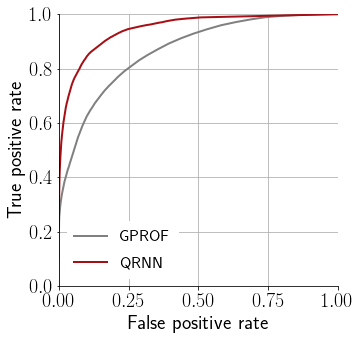

In [18]:
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(fpr_gprof, tpr_gprof, label="GPROF", c="grey")
ax.plot(fpr_qrnn, tpr_qrnn, label="QRNN")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.legend()